<a href="https://colab.research.google.com/github/AndresMontesDeOca/RegresionAvanzada/blob/main/TrabajoPractico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Instalacion de Librerias

In [96]:
# Instalacion de Paquetes
!pip install pingouin # No incluido en Google Colab
# !pip install scipy
# !pip install statsmodels

# Version rpy2 que no tiene problemas de compatibilidad
!pip install rpy2==3.5.1

# Cargamos Librerias y Datos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from scipy import stats as st
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tools.tools as smt

# Ignorar Warnings
import warnings
warnings.filterwarnings('ignore')

# Asthetics
sns.set(style='ticks', context='notebook', palette='colorblind', font_scale=1, color_codes=True)

# Recursion limit errors with R Magic
import sys
# sys.setrecursionlimit(50000)

# Activamos R magic
%load_ext rpy2.ipython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


#### Carga de Datos desde Goolge Drive

In [97]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

################################# Datasets ###################################
# Grasa de Cerdos
id = '153lGVzdixcHT-keKg8qmvaoWdPHg6_tB'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('grasacerdos.xlsx')
dataG = pd.read_excel('grasacerdos.xlsx', index_col='Obs') # Cargamos el Dataset
dataG = dataG.replace(to_replace=',', value='.', regex=True) # Reemplazo , por .
dataG = dataG.astype('float') # Transformo en float
%R -i dataG
######################################################
# Peso, Edad, Colesterol
id = '17Dv1WcWlc9ojWa6bnSfD7TCRaVKCKqj0'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('peso_edad_colest.xlsx')
dataP = pd.read_excel('peso_edad_colest.xlsx')
%R -i dataP
######################################################
# Energia
id = '15R-MejMHi1D0y0JUEGxyC3-fsjpYHEUv'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('energia.xlsx')
dataE = pd.read_excel('energia.xlsx')
dataE.rename(columns={'Energía':'Energia'}, inplace=True)
%R -i dataE

In [98]:
%%R

### MVN Henze-Zirkler Test ### -> Lento
# # system(sudo apt install libgsl-dev)
# install.packages('MVN')

# # QQ Plot, Bonferroni ### -> Lento
# install.packages('car')

# # LRM Tests ### -> Rapido
# install.packages('lmtest')

# ## Box-Cox Transformation ### -> Rapido
# install.packages('MASS')

# # Wald Test ### -> Rapido
# install.packages('aod')


####################################
### Installation Status ###
# print(system.file(package='MVN'))

NULL


# Capitulo I: Regresion Lineal Simple

## Ejercicio 1.1 - Correlacion

In [99]:
# Dataset Grasa de cerdos
data = dataG
display(dataG.head())

,PV,EGD
Obs,,
1,56.81,16.19
2,70.40,22.00
3,71.73,19.52
4,75.10,31.00
5,79.65,23.58


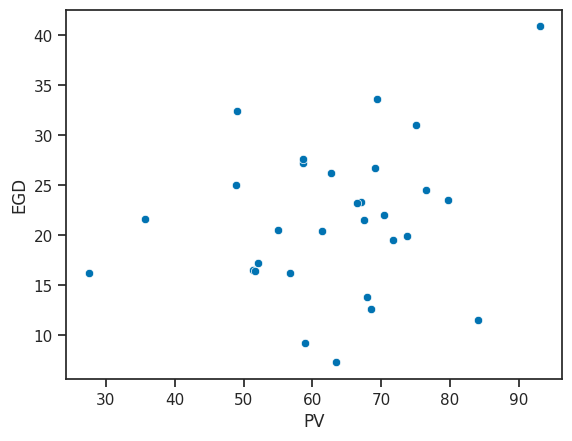

In [100]:
# Punto a -> Scatterplot e interpretacion
sns.scatterplot(data=data, x='PV', y='EGD')
plt.show()

a) No se observa patron de asociacion lineal en el grafico de dispersion

In [101]:
# Calculo del Coeficiente de Correlacion
# display(data.head())
display(pg.corr(data.PV, data.EGD, method='pearson'))
display(pg.corr(data.PV, data.EGD, method='spearman'))
display(pg.corr(data.PV, data.EGD, method='kendall'))

# Verificacion de Normalidad de las Variables
print('\n', pg.normality(data.PV))
print('\n', pg.normality(data.EGD))
print('\n', pg.multivariate_normality(data)) # Henze-Zirkler Test, H0 -> Multiv Normal Dist


,n,r,CI95%,p-val,BF10,power
pearson,30,0.254343,"[-0.12, 0.56]",0.174994,0.546,0.27791


,n,r,CI95%,p-val,power
spearman,30,0.166185,"[-0.21, 0.5]",0.380118,0.142724


,n,r,CI95%,p-val,power
kendall,30,0.112644,"[-0.26, 0.45]",0.395032,0.091095



            W      pval  normal
PV  0.975331  0.692481    True

             W      pval  normal
EGD  0.985135  0.939467    True

 HZResults(hz=0.25394365632841115, pval=0.9049686197809698, normal=True)


- b) Los Coeficientes de Correlacion no son significativos, se observa que los todos los IC de los distintos tests incluyen el 0
- c) No hay suficiente evidencia para rechazar el supuesto de Normalidad Bivariada

## Ejercicio 1.2 - Modelo Lineal Simple

In [102]:
# Dataset de Colesterol, Peso y Edad
data = dataP
data.head()

,peso,edad,colest
0,84,46,354
1,73,20,190
2,65,52,405
3,70,30,263
4,76,57,451


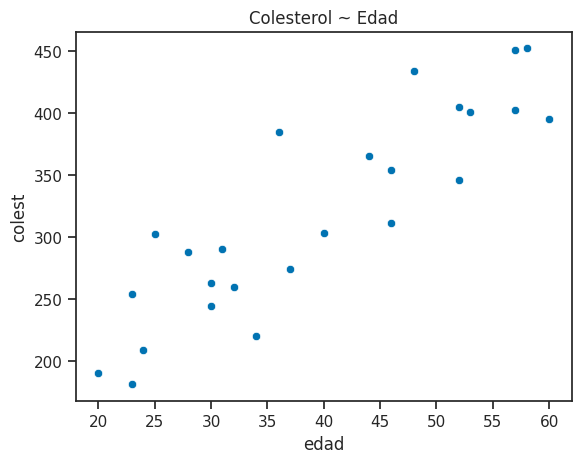

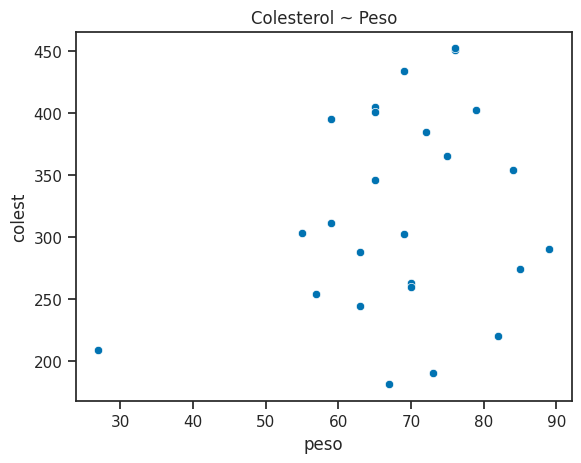

In [103]:
# Diagramas de Dispersion
sns.scatterplot(data=data, x='edad', y='colest')
plt.title('Colesterol ~ Edad')
plt.show()

sns.scatterplot(data=data, x='peso', y='colest')
plt.title('Colesterol ~ Peso')
plt.show()

a) Si, pareciera existir una relacion lineal entre Peso y Colesterol

In [104]:
# Generamos el modelo lineal en R
%%R
data <- dataP

model = lm('colest ~ edad', data=data)
# print(summary(model))
print(model$coef)

(Intercept)        edad 
  95.502004    5.670842 


- b)  El coeficiente de la variable independiente edad es de 5.67 y el de la ordenada al origen 95.5

In [105]:
%%R

# Modelo
print(summary(model))

# Test Wald
library(aod)
wald.test(Sigma = vcov(model), b = coef(model), Terms = 1) # Cuerpo| H0: Coef = 0 (Var no significativa)


Call:
lm(formula = "colest ~ edad", data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-68.311 -22.602  -2.627  27.589  85.348 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  95.5020    26.2545   3.638  0.00138 ** 
edad          5.6708     0.6345   8.937 6.09e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 39.69 on 23 degrees of freedom
Multiple R-squared:  0.7764,	Adjusted R-squared:  0.7667 
F-statistic: 79.87 on 1 and 23 DF,  p-value: 6.094e-09

Wald test:
----------

Chi-squared test:
X2 = 13.2, df = 1, P(> X2) = 0.00028


- c) Tanto el test del modelo, como el test de Wald de la varible independiente indican que ambos son significativos

In [106]:
# Predicciones
data = dataP
print(data.edad.max())

60


In [107]:
# predichos <- predict(object=model, interval='prediction', level=0.95)
# Creo los datos a predecir
to_predict = [25, 48]
newdata = pd.Series(to_predict, name='edad').to_frame()

# Los exporto a R
%R -i newdata

In [108]:
%%R

predict(object=model, newdata=newdata, interval='confidence')

       fit      lwr      upr
0 237.2730 212.1954 262.3507
1 367.7024 347.8058 387.5990


- d) 237.27 y 367.7 de Colesterol para 25 y 48 anos respectivamente. Para 80 anos no deberia estimarse, ya que esta fuera del dominio del modelo

In [109]:
%%R

# Normalidad de Residuos Analitica
print(shapiro.test(model$resid))

# Normalidad de residuos grafica
# library(car)
# qqPlot(model$resid)


	Shapiro-Wilk normality test

data:  model$resid
W = 0.96478, p-value = 0.5175



- e1) No hay suficiente evidencia para rechazar el supuesto de Normalidad de los residuos

In [110]:
# # Residuals Variance (Homosedasticity)
# Analisis Analitico (Breusch-Pagan Test) -> R | H0: Residuos Homocedasticos
%%R

# library(lmtest)
# print(bptest(model))

resid = model$resid
fitted = model$fitted.values

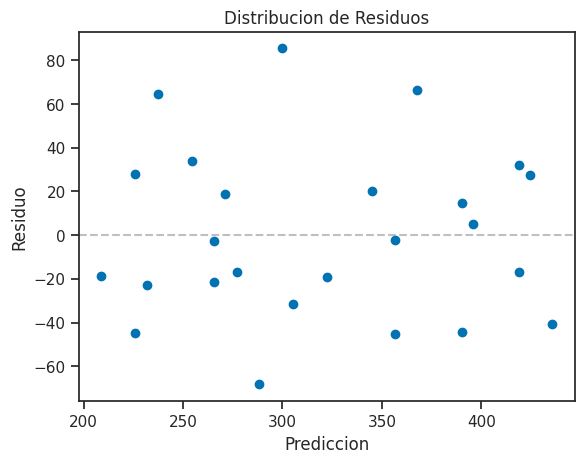

In [111]:
# # Analsis Grafico -> Python

# Importo Datos desde R
%R -o resid
%R -o fitted

plt.scatter(x=fitted, y=resid)
plt.xlabel( 'Prediccion')
plt.ylabel('Residuo')
plt.title('Distribucion de Residuos')
plt.axhline(color='grey', linestyle='dashed', alpha=0.5)
plt.show()
# No se observa estructura de embudo

- e2) Tampoco hay suficiente evidencia para rechazar su homocedasticidad. En el analisis grafico no se observa la forma de "embudo"

## Ejercicio 1.3 - Transformacion de Variables

,Hora,Energia
0,1,598
1,2,527
2,3,530
3,4,528
4,5,452


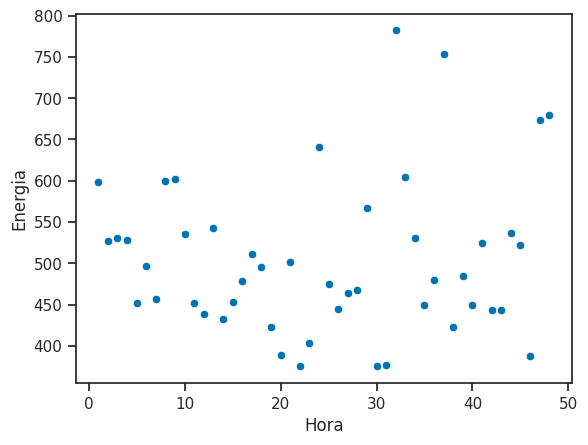

In [182]:
data = dataE
display(dataE.head())

sns.scatterplot(data=data, x='Hora', y='Energia')
plt.show()

- a) El Scatterplot no muestra asociacion lineal entre las variables

In [235]:

%%R

model = lm('Energia ~ Hora', data=data)
print(summary(model))
print(shapiro.test(model$resid))


Call:
lm(formula = "Energia ~ Hora", data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-131.12  -60.60  -24.31   37.29  273.84 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 491.4894    27.5044  17.869   <2e-16 ***
Hora          0.5208     0.9772   0.533    0.597    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 93.79 on 46 degrees of freedom
Multiple R-squared:  0.006138,	Adjusted R-squared:  -0.01547 
F-statistic: 0.2841 on 1 and 46 DF,  p-value: 0.5966


	Shapiro-Wilk normality test

data:  model$resid
W = 0.92988, p-value = 0.006752



- b1) Lavariable Hora no parece ser significativa en el modelo
- b2) Se rechaza el supuesto de Normalidad de los datos

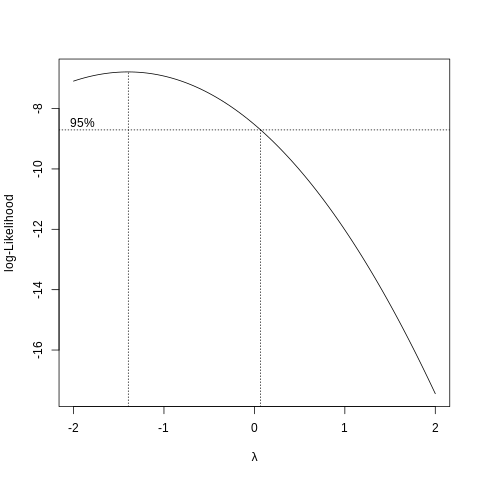

In [272]:
# Box Cox Transformation -> R
%%R
data = dataE
library(MASS)

# Buscamos el Lambda  optimo -> Si Lambda  = 0 -> log10(y) | y**Lambda
boxcox(object = model, plotit=TRUE)

In [ ]:
- Vamos a probar con un Lambda de -1.5

In [288]:
%%R
# boxcox_results <- boxcox(object = model, plotit=TRUE)

lmb = -1.5

model2 = lm('Energia**lmb ~ Hora', data=data)
print(summary(model2))
print(shapiro.test(model2$resid))


Call:
lm(formula = "Energia**lmb ~ Hora", data = data)

Residuals:
       Min         1Q     Median         3Q        Max 
-4.759e-05 -1.257e-05  1.019e-06  1.340e-05  4.443e-05 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 9.319e-05  6.764e-06  13.777   <2e-16 ***
Hora        3.860e-09  2.403e-07   0.016    0.987    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.307e-05 on 46 degrees of freedom
Multiple R-squared:  5.607e-06,	Adjusted R-squared:  -0.02173 
F-statistic: 0.0002579 on 1 and 46 DF,  p-value: 0.9873


	Shapiro-Wilk normality test

data:  model2$resid
W = 0.9797, p-value = 0.5661



- c) El nuevo modelo no parece ser significativo, pero los residuos si son normales. No se que hacer en este caso

In [293]:
# Analisis de Diagnostico
%%R

library(lmtest)
print(shapiro.test(model2$resid))
print(bptest(model2))
print(dwtest(model2, alternative='two.sided', iterations=1000))


	Shapiro-Wilk normality test

data:  model2$resid
W = 0.9797, p-value = 0.5661


	studentized Breusch-Pagan test

data:  model2
BP = 3.364, df = 1, p-value = 0.06664


	Durbin-Watson test

data:  model2
DW = 1.8827, p-value = 0.5734
alternative hypothesis: true autocorrelation is not 0



- El nuevo modelo con la variable transformada, cumple todos los supuestos

In [299]:
# Datos a Predecir (Python)
to_predict = [27.5]
newdata = pd.Series(to_predict, name='Hora').to_frame()

%R -i newdata

In [302]:
# Prediccion de Horas = 27.5
%%R


# Bandas de Prediccion
predichos_prediction <- predict(object=model2, interval='prediction', level=0.95, newdata=newdata)
predichos_confidence <- predict(object=model2, interval='confidence', level=0.95, newdata=newdata)
# nuevos_datos <- data.frame(predichos, data, data$Energia**lmb)
# print(head(nuevos_datos))


print(predichos_prediction)
print(predichos_confidence)

           fit          lwr          upr
0 9.329975e-05 4.636507e-05 0.0001402344
           fit          lwr          upr
0 9.329975e-05 8.644266e-05 0.0001001568


In [309]:
# Reverse Transformation
%%R


base = 9.329975e-05
exp = lmb
# print(base**exp)
print(log(base**exp, base))

# print(base)

[1] -1.5
